In [56]:
pip install tifffile

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install wand

Note: you may need to restart the kernel to use updated packages.


In [58]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [60]:
import numpy as np
import os
import tifffile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import wand
import wandb
import pandas

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, jaccard_score

### Import the Images
There should only be 1 this time

In [61]:
data_dir = "parry_town_train_aoi_kfold_512/"
image_dir = data_dir + "sentinel_raster_maps/"
target_dir = data_dir + "target_raster_maps/"

no_images = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(image_dir))))
    
no_targets = len(list(filter(lambda x:x.endswith('.tiff') or x.endswith('.tif'), os.listdir(target_dir))))

assert no_images == no_targets
assert no_images == 1

X_raster = tifffile.imread("{}image_{}.tiff".format(image_dir, "0"))
#X_raster = X_raster[:,:,np.r_[0,1,2,3,4,5,6]]

y_raster = np.array(Image.open("{}target_{}.tiff".format(target_dir, "0")))
# images = []
# targets = []

# shp = tifffile.imread("{}image_{}.tiff".format(image_dir, "0")).shape
# tilesize = shp[0]
# no_bands = shp[2]

# X = np.empty((tilesize**2*no_images, no_bands))
# y = np.empty(tilesize**2*no_images)

# for i in range(no_images):
#     #Sentinel band (image) raster - X
#     image_data = tifffile.imread("{}image_{}.tiff".format(image_dir, i))
#     images.append(image_data)
    
#     X[i*tilesize**2:(i+1)*tilesize**2, :] = np.reshape(image_data, (tilesize**2, no_bands))
    
#     #Target raster - y
#     target = Image.open("{}target_{}.tiff".format(target_dir, i))
#     #print(np.array(target.getdata()).shape)
#     targets.append(np.reshape(list(target.getdata()), (tilesize, tilesize)))
    
#     y[i*tilesize**2:(i+1)*tilesize**2] = np.array(target.getdata())
    
# y = y.astype(int)
    
# print(X.shape)
# print(y.shape)
# np.unique(y, return_counts = True)

### Crop the images
To avoid including areas I haven't highlighted in the training/test sets used for f1 score evaluation

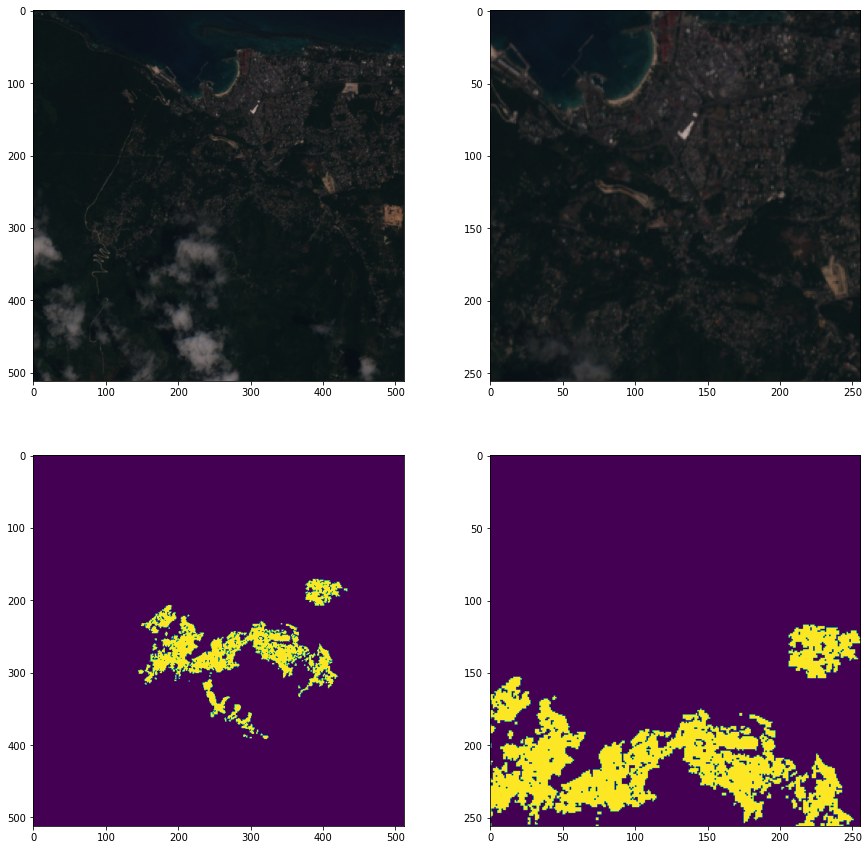

In [62]:
fig, ax = plt.subplots(2,2, figsize = (15,15))
ax[0,0].imshow(X_raster[:,:,0:3])
ax[0,1].imshow(X_raster[54:310,170:426,0:3]) #Indices based on kfold_aoi geojson (roughly)
ax[1,0].imshow(y_raster)
ax[1,1].imshow(y_raster[54:310,170:426])

X_raster_crop = X_raster[54:310,170:426,:]
y_raster_crop = y_raster[54:310,170:426]

In [63]:
X_data = X_raster_crop.reshape((X_raster_crop.shape[0]*X_raster_crop.shape[1], X_raster_crop.shape[2]), order='F')
y_data = y_raster_crop.reshape((y_raster_crop.shape[0]*y_raster_crop.shape[1]), order='F')
y_data = y_data.astype(int)
#order = 'F' keeps the columns in order so we have X_train = [col1, col2, col3, col4]


### Construct the iterator for the k-fold cross validation
See sklearn GridSearchCV docs

In [64]:
def get_cv_iterable(data, original_shape, k = 5):
    """
    Gets an iterable over the indices of x/y_data_train
    that takes vertical slices of the original raster
    data. 80:20 split.
    
    data - X_data_train or y_data_train as numpy arrays
           as a list of N features
           
    original_shape - tuple of original dimensions for
                     X_data_train, y_data_train
                     i.e if data has N = 256*256 = 65536 
                     then original shape might be (256,256)
                     
    k - number of folds
                     
    Return - iterator over (train, test) splits as arrays
             of indices
    """
    img_height = original_shape[0] #No rows in original
    img_width = original_shape[1] #No columns in original
    
    train_test_indices = []
    
    block_length = img_height*(img_width//k) #No of pixels in a column * No of columns in each block for k fold
    for i in range(k-1):
        test_indices = np.r_[i*block_length:(i+1)*block_length] #Block of test indices (contiguous)
        train_indices = list(set(range(len(data))) - set(test_indices)) #Train indices are what's left
        
        train_test_indices.append((train_indices, test_indices))
        
    test_indices = np.r_[(k-1)*block_length:len(data)] #Do this outside the loop in case rounding means array length not exactly divisible by block size
    train_indices = list(set(range(len(data))) - set(test_indices))
    
    train_test_indices.append((train_indices, test_indices))
    
    return iter(train_test_indices)
    

## Initialise Classifier & Perform Grid Search

In [65]:
rf_classifier = RandomForestClassifier(random_state = 0, class_weight = "balanced_subsample", min_samples_split=5)
k_folds = 5
val_frac = 5 #5 for 1/5th etc

#Split off a validation set
X_data_train = X_raster_crop[:, :-X_raster_crop.shape[1]//val_frac, :].reshape((-1, X_raster_crop.shape[2]), order='F')
y_data_train = y_raster_crop[:, :-y_raster_crop.shape[1]//val_frac].reshape((-1,1), order='F')
y_data_train = np.ravel(y_data_train.astype(int))

X_train_shape = (X_raster_crop[:, :-X_raster_crop.shape[1]//val_frac, :].shape[0], X_raster_crop[:, :-X_raster_crop.shape[1]//val_frac, :].shape[1])

X_data_val = X_raster_crop[:, -X_raster_crop.shape[1]//val_frac:, :].reshape((-1,X_raster_crop.shape[2]), order='F')
y_data_val = y_raster_crop[:, -y_raster_crop.shape[1]//val_frac:].reshape((-1,1), order='F')
y_data_val = np.ravel(y_data_val.astype(int))

In [66]:
max_depths = [15,16,17,18,19,20] #[5,10,15,16,17,18,19,20,21,22,23,24,25,30,35,40,45,50, None]
min_samples_splits = [4,5,6,7,8]
min_samples_leafs = [1]
criteria = ['gini']

parameters = {'max_depth':max_depths, 'min_samples_split':min_samples_splits, 'min_samples_leaf':min_samples_leafs, 'criterion':criteria}

dataset_iter = get_cv_iterable(X_data_train, X_train_shape, k_folds) #Iterable of (train, test) indices for k fold cross validation
rf_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(rf_classifier, parameters, cv=dataset_iter, scoring=rf_scorer, n_jobs=-1)

In [67]:
grid_search

GridSearchCV(cv=<list_iterator object at 0x7f8cbc3e1a10>, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=5,
                                              min_we...tion_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, ra

In [68]:
%%time
grid_search.fit(X_data_train, y_data_train)

CPU times: user 15.5 s, sys: 180 ms, total: 15.7 s
Wall time: 3min 24s


GridSearchCV(cv=<list_iterator object at 0x7f8cbc3e1a10>, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=5,
                                              min_we...tion_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, ra

In [69]:
grid_search.best_score_

0.5263660979094931

In [70]:
np.bincount(y_data_train)

array([44369,  7855])

## Plot Results

In [71]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_data)

In [72]:
best_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=17, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=6, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

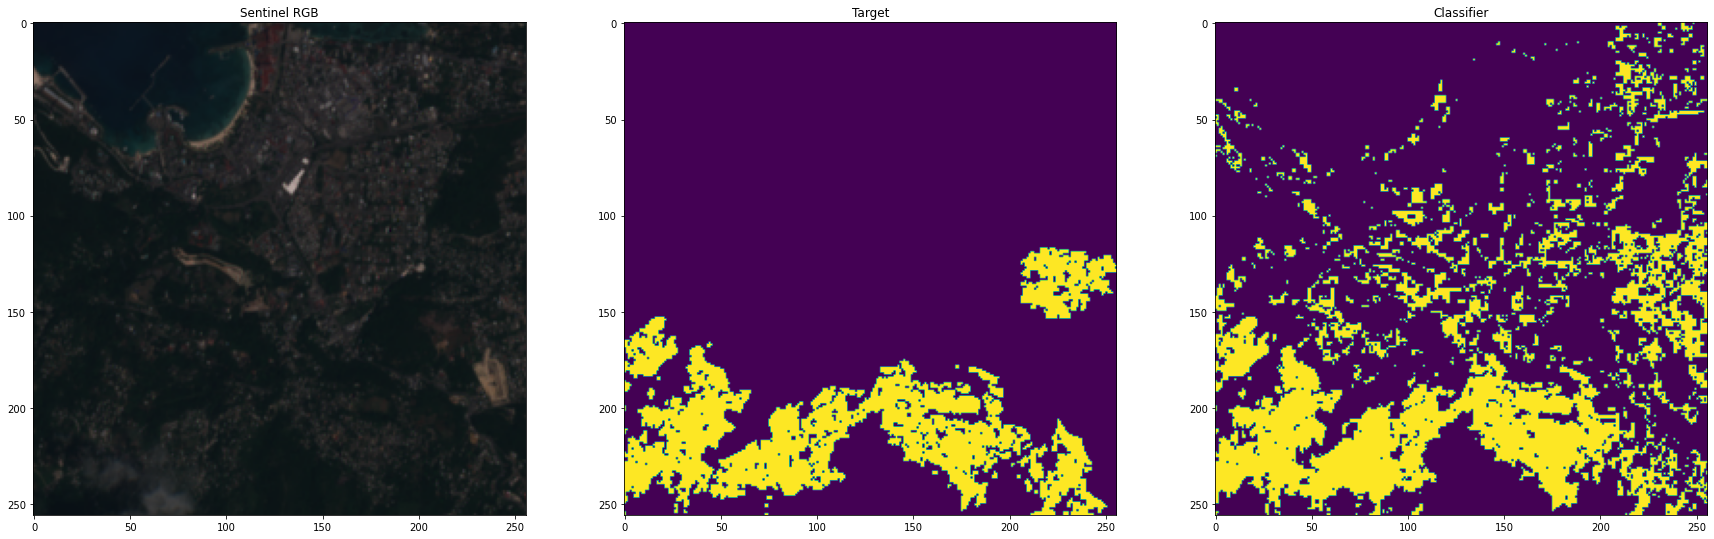

In [73]:
resultsFig, resultsAx = plt.subplots(1,3, figsize = (30,30))
resultsAx[0].imshow(X_raster_crop[:,:,0:3])
resultsAx[0].title.set_text('Sentinel RGB')
resultsAx[1].imshow(y_data.reshape((256,256), order='F'))
resultsAx[1].title.set_text('Target')
resultsAx[2].imshow(y_pred.reshape((256,256), order='F'))
resultsAx[2].title.set_text('Classifier')

In [74]:
df = pandas.DataFrame.from_dict(grid_search.cv_results_)
#df.to_excel("GridSearchCV_{}fold_{}val_jac.xlsx".format(k_folds, val_frac))

In [75]:
#10 BANDS
# RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
#                        class_weight='balanced_subsample', criterion='gini',
#                        max_depth=18, max_features='auto', max_leaf_nodes=None,
#                        max_samples=None, min_impurity_decrease=0.0,
#                        min_impurity_split=None, min_samples_leaf=1,
#                        min_samples_split=7, min_weight_fraction_leaf=0.0,
#                        n_estimators=100, n_jobs=None, oob_score=False,
#                        random_state=0, verbose=0, warm_start=False)

#10 BANDS MIOU
#RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
#                        class_weight='balanced_subsample', criterion='gini',
#                        max_depth=18, max_features='auto', max_leaf_nodes=None,
#                        max_samples=None, min_impurity_decrease=0.0,
#                        min_impurity_split=None, min_samples_leaf=1,
#                        min_samples_split=7, min_weight_fraction_leaf=0.0,
#                        n_estimators=100, n_jobs=None, oob_score=False,
#                        random_state=0, verbose=0, warm_start=False)

In [76]:
f1_score(y_data_val, best_rf.predict(X_data_val))

0.4187571733070995

## Extract specific areas for presentation

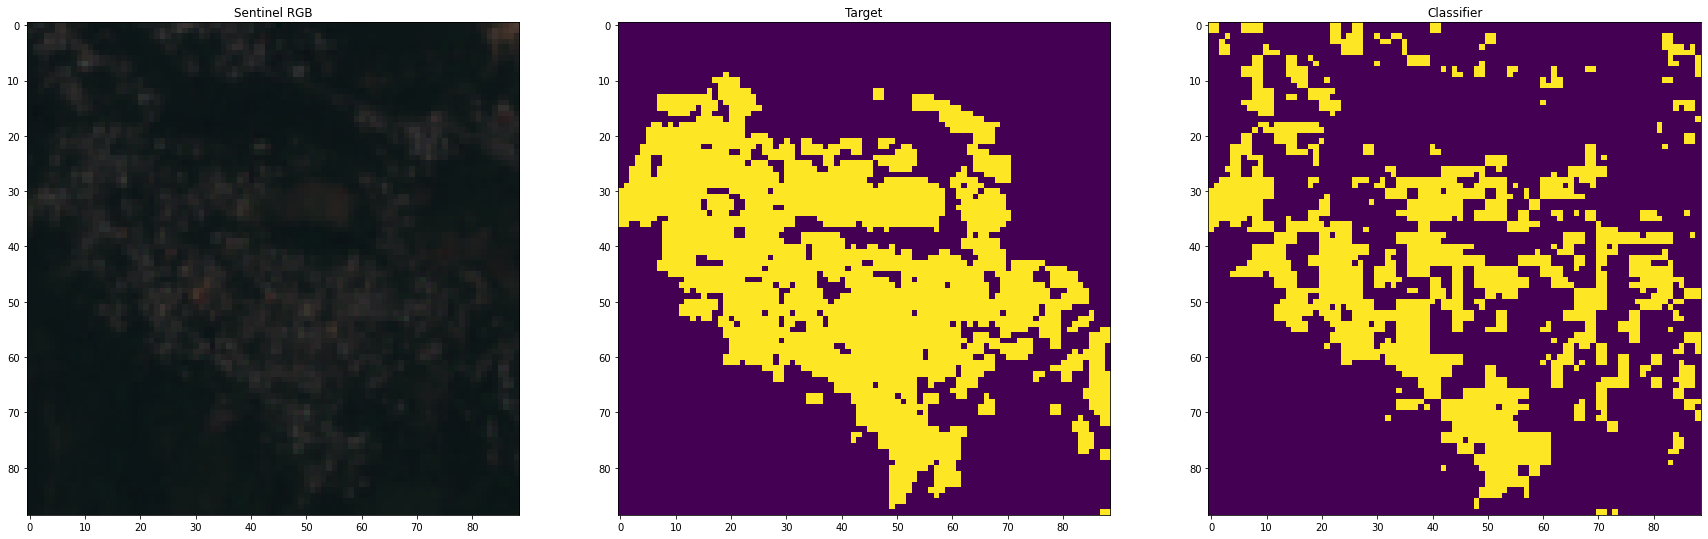

In [35]:
resultsFig, resultsAx = plt.subplots(1,3, figsize = (30,30))
resultsAx[0].imshow(X_raster_crop[166:255,126:215,0:3])
resultsAx[0].title.set_text('Sentinel RGB')
resultsAx[1].imshow(y_data.reshape((256,256), order='F')[166:255,126:215])
resultsAx[1].title.set_text('Target')
resultsAx[2].imshow(y_pred.reshape((256,256), order='F')[166:255,126:215])
resultsAx[2].title.set_text('Classifier')

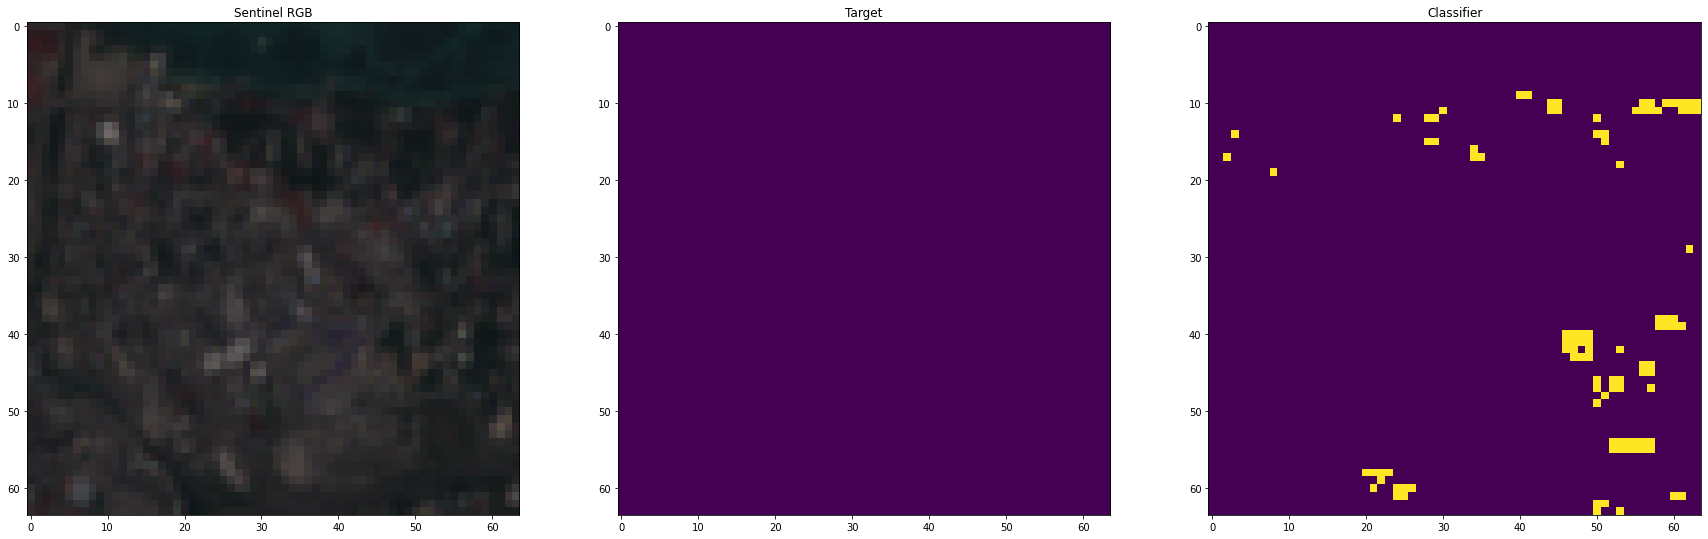

In [39]:
resultsFig, resultsAx = plt.subplots(1,3, figsize = (30,30))
resultsAx[0].imshow(X_raster_crop[0:64,126:190,0:3])
resultsAx[0].title.set_text('Sentinel RGB')
resultsAx[1].imshow(y_data.reshape((256,256), order='F')[0:64,126:190])
resultsAx[1].title.set_text('Target')
resultsAx[2].imshow(y_pred.reshape((256,256), order='F')[0:64,126:190])
resultsAx[2].title.set_text('Classifier')

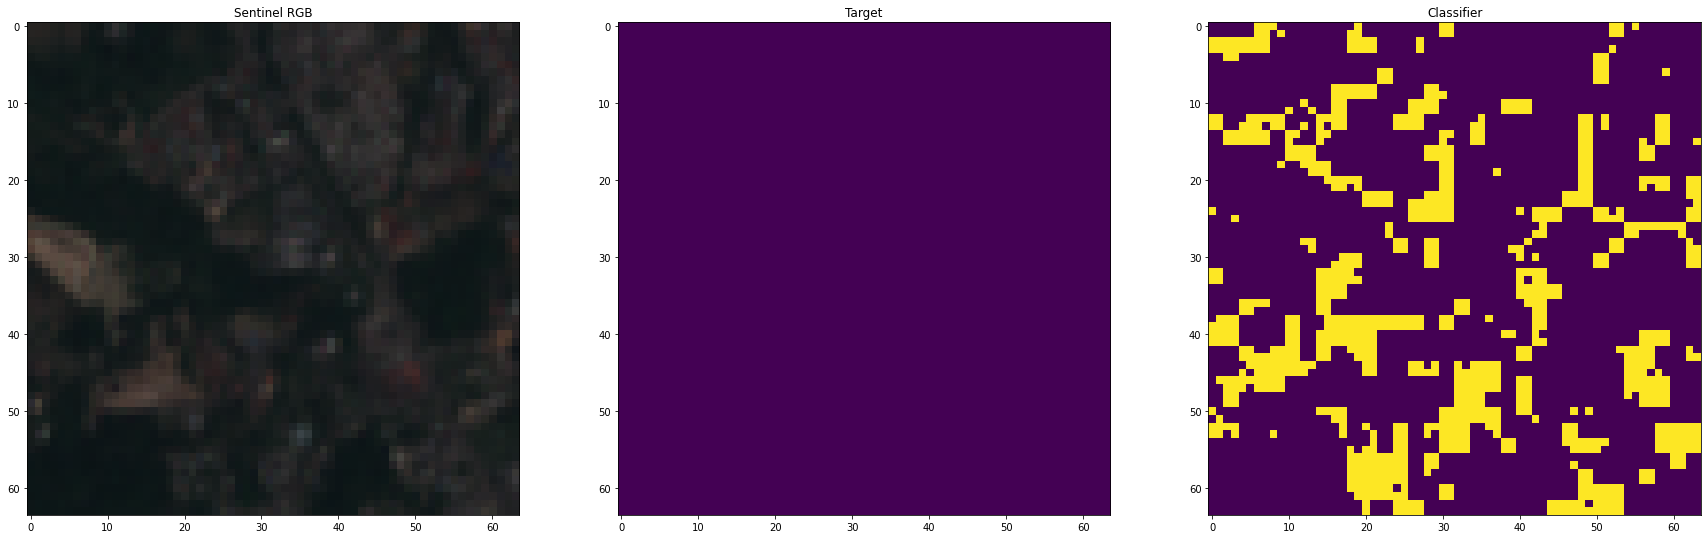

In [50]:
resultsFig, resultsAx = plt.subplots(1,3, figsize = (30,30))
resultsAx[0].imshow(X_raster_crop[100:164,100:164,0:3])
resultsAx[0].title.set_text('Sentinel RGB')
resultsAx[1].imshow(y_data.reshape((256,256), order='F')[100:164,100:164])
resultsAx[1].title.set_text('Target')
resultsAx[2].imshow(y_pred.reshape((256,256), order='F')[100:164,100:164])
resultsAx[2].title.set_text('Classifier')

In [36]:
grid_search.cv_results_

{'mean_fit_time': array([2.99089241, 3.02216492, 3.02633238, 3.14033508, 3.21321039,
        3.30898519, 3.35925503, 3.2759388 , 3.26181364, 3.33363438,
        3.34379382, 3.33799014, 3.23893495, 3.24010696, 3.28938174,
        3.44739132, 3.28810835, 3.18829389, 3.14952641, 3.27749314,
        3.35626769, 3.42526336, 3.36984076, 3.3858099 , 3.31200953,
        3.38462005, 3.37342863, 3.36138196, 3.358182  , 3.31393933]),
 'std_fit_time': array([0.04897683, 0.02932832, 0.03561482, 0.07093329, 0.03223672,
        0.03486893, 0.06699916, 0.06291403, 0.03554205, 0.10902067,
        0.06302573, 0.05740594, 0.02353459, 0.04284498, 0.06989151,
        0.09625703, 0.08183848, 0.02169281, 0.04603573, 0.06644656,
        0.05102058, 0.05271211, 0.03546828, 0.06255167, 0.0423908 ,
        0.02583079, 0.04721944, 0.03939928, 0.04814256, 0.04826191]),
 'mean_score_time': array([0.09502196, 0.09304509, 0.09899807, 0.10499477, 0.10531502,
        0.11505828, 0.11167054, 0.10869884, 0.10628963, 0.10

In [47]:
np.bincount(y_pred.reshape((256,256), order='F')[:86,-86:].reshape(1,-1)[0])

array([6536,  860])